## Separate Estimation and Optimization

In this notebook we will run through different SEO approaches to get a better understanding of how they work and how they performe. Therefore, we will use a real world dataset from a fast casual restaurant in Stuttart called YAZ. The main ingredients for the meals at YAZ, e.g. steak, lamb, fish ect. are prepared at a central factory and are deep-frozen to achieve longer shelf lives. Depending on the estimated demand for the next day, the ingredients are defrosted over night. These defrosted ingredients/meals then have to be sold within the following day. Unsold ingredients have to be disposed of so YAZ is facing a typical single-period inventory problem.  

------------------------
### Load libraries

Before we are ready to start we have to load the libraries we will need in the following.

In [1]:
from ddop.datasets.load_datasets import load_data
from ddop.newsvendor import ExponentialSmoothingNewsvendor
from ddop.metrics.costs import calc_avg_costs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas
import scipy
from scipy.stats import norm

Using TensorFlow backend.


You can install the missing packages by uncommenting and executing the following cell:

In [2]:
#pip install ddop sklearn matplotlib numpy scipy seaborn 

-----------------
### Data

As mentioned above, we will us the YAZ dataset for this tutorial. So lets first load the data and have a look at it.

In [3]:
data = load_data("yaz_multioutput.csv")

In [4]:
data

Montag  Dienstag  Mittwoch  Donnerstag  Freitag  Samstag  Sonntag  \
0         0         0         0           0        1        0        0   
1         0         0         0           0        0        1        0   
2         0         0         0           0        0        0        1   
3         1         0         0           0        0        0        0   
4         0         1         0           0        0        0        0   
..      ...       ...       ...         ...      ...      ...      ...   
755       0         1         0           0        0        0        0   
756       0         0         1           0        0        0        0   
757       0         0         0           1        0        0        0   
758       0         0         0           0        1        0        0   
759       0         0         0           0        0        1        0   

     MONTH_JAN  MONTH_FEB  MONTH_MAR  ...  MONTH_OCT  MONTH_NOV  MONTH_DEC  \
0            0          0          0  ...          1          0          0   
1            0          0          0  ...          1          0          0   
2            0          0          0  ...          1          0          0   
3            0          0          0  ...          1          0          0   
4            0          0          0  ...          1          0          0   
..         ...        ...        ...  ...        ...        ...        ...   
755          0          0          0  ...          0          1          0   
756          0          0          0  ...          0          1          0   
757          0          0          0  ...          0          1          0   
758          0          0          0  ...          0          1          0   
759          0          0          0  ...          0          1          0   

     YEAR_2013  YEAR_2014  YEAR_2015  ISHOLIDAY  WEEKEND  STEAK  HAEHNCHEN  
0            1          0          0          0        0     36         40  
1            1          0          0          0        1     30         44  
2            1          0          0          0        1     16         19  
3            1          0          0          0        0     22         28  
4            1          0          0          0        0     29         22  
..         ...        ...        ...        ...      ...    ...        ...  
755          0          0          1          0        0     32         47  
756          0          0          1          0        0     38         38  
757          0          0          1          0        0     24         47  
758          0          0          1          0        0     32         50  
759          0          0          1          0        1     20         45  

[760 rows x 26 columns]

In [5]:
data = data.drop(labels=[80,81,82,83,84,85,443,444,445,446,447,448,449,450,451,452])

As we can see our dataset stores the demand data for two products, steak and Fisch, over the last 760 days. In addition, we have a bunch of different demand features that may have predictive power. These features include information about the day, month, year, lag demand, weather conditons and more. For  detailed information about all features check out the dataset documentation <u>here</u>. (TODO: Add reference here)

---------------------------------------------
### Traditional parametric approach

As first step of this tutorial lets have a look at the traditional parametric approach. As we have already learned, the traditional way of solving the newsvendor problem when the underlying demand distribution is unknown is to assume that the demand falls in a family of parametric distributions, estimate the parameters based on historical demands, and then solve the initial optimization problem. 

#### Preprocess data

For the traditional parametric approach we only need the historical demand without any feature information. Moreover, for simplicity, we will only consider the demand for steak. 

In [6]:
y = data["STEAK"]

Given the data, lets split it into train and test set, whereby the test set contains 25% of the original dataset.

In [7]:
y_train, y_test = train_test_split(y, train_size=0.75, shuffle=False)

#### Estimate parameters

In this step we have to fit a distribution function to our data and calculate its parameters.
To see how our data is distributed, we can use a normalised histogram. 

[]

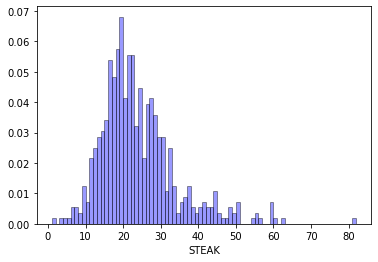

In [8]:
# normalised histogram
hist = sns.distplot(y_train, hist=True, norm_hist=True, kde=False,
             bins=y_train.max()-y_train.min(), color = 'blue',
             hist_kws={'edgecolor':'black'})
hist.plot()

Given the plot above let us assume the demand of steak is normally distributed.
Fitting a normal distribution to the data gives us the following result:

[]

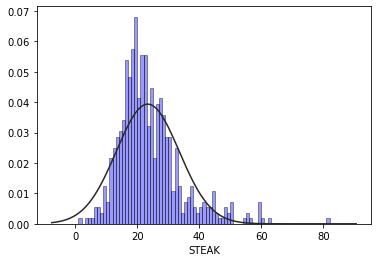

In [9]:
# seaborn histogram
hist = sns.distplot(y_train, fit=scipy.stats.norm, hist=True, norm_hist=True, kde=False,
             bins=y_train.max()-y_train.min(), color = 'blue',
             hist_kws={'edgecolor':'black'})
hist.plot()

With mean and standard deviation:

In [10]:
mean = y_train.mean()
print("mean: " + str(round(mean,2)))
std = y_train.std()
print("std: " + str(round(std,2)))

mean: 23.36
std: 10.15


#### Set cost parameters and service level

To calculate the optimal inventory quantity we have to set our under- and overage costs, as well as the corresponding service level:

In [11]:
cu = 15
co = 5
alpha = cu/(cu+co)

#### Solve optimization problem

Now that we have estimated the distribution parameters and set our service level, we can calculate the optimal inventory quantity by solving the newsvendor optimization problem that is again given by:

\begin{equation}q^*=F^{-1}\biggl(\frac{cu}{cu+co}\biggl)=F^{-1}(\alpha)\end{equation}

In [12]:
q = norm(mean, std).ppf(alpha)
print("The optimal inventory quantity is: " + str(q))

The optimal inventory quantity is: 30.20467906302532


#### Cost calculation

Finally let us calculate the average costs for the test set to see how goot the traditional parametric approch performs. Therefore, we assume the demand to be stationary so our inventory quantity will constant over for all planning periods. 

In [13]:
y_pred = np.full(y_test.shape[0],q)
avg_costs = calc_avg_costs(y_test, y_pred, cu, co)
print("Average costs: "+str(avg_costs[0]))

Average costs: -65.75677767303732


------------------------------------
### SEO using forcasting model

In the last step we have assumed the demand to be stationary. However, in many real-world situations this assumption is not true, as the demand might be seasonal, follow a trend or is influenced by factors like the weather conditions. Now, in this part of the tutorial, we will have a look at SEO approaches that are using demand forcasting/prediction models to take such factors into account. For instance, we will look at the following two approaches: 

1. [Exponential Smoothing Newsvendor](#Exponential-Smoothing-Newsvendor)
2. [Random Forest Newsvendor](#Random-Forest-Newsvendor)

The first approch is only considering historical demand data whereas the second one also takes into account auxiliary data (features).   


#### Exponential Smoothing Newsvendor

As the name suggests, this model is using exponential smoothing as underlying forcasting model. The idea behind this approach is to predict demand as a function of past demand values. There are tree different types of Exponential Smoothing:
1. single exponential smoothing for stationary data,
2. double exponential smoothing for data with trend or
3. triple exponential smoothing for data with trend and seasonality.

Consequently, depending on the type of Exponential smoothing, we are able to consider trend and seasonality in our Data.

##### Preprocess data

Just like for the [Traditional parametric approach](#Traditional-parametric-approach), we only need our historical demand data without any feature information fo this model. So lets select our data and split it into train and test set.

In [14]:
y = data['STEAK']
y_train, y_test = train_test_split(y, train_size=0.75, shuffle=False)

##### Initialize and fit model

Lets now use triple exponential smoothin. Therefore, we have to set the following parameters: 
- `trend`: "mul", "add" - whether to use an multiplicative or additive trend   
- `damped`: bool - whether to dampe the trend
- `seasonal`: "mul", "add" - whether to use an multiplicative or additive seasonality 
- `seasonal_periods`: int - The number of periods in a complete seasonal cycle, e.g., 4 for quarterly data or 7 for daily data with a weekly cycle.

We set both, `trend` and `seasonal` to `"add"`. As we have daily data we set `seasonal_periods` to `7` for a weekly cycle. As we will calculate the the inventory quantities for the entire test set, the trend might be unrealistic for such a long planing horizon. Consequently we set the parameter `damped` to `True`. Damping the trend means reducing the size of the trend over the time.

In [15]:
mdl_ESN = ExponentialSmoothingNewsvendor(cu,co,trend="add", damped=True, seasonal='add',seasonal_periods=7)

In [16]:
mdl_ESN.fit(y_train)

c:\users\andre\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\users\andre\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


ExponentialSmoothingNewsvendor(co=5, cu=15, damped=array([ True]),
                               damping_slope=array([None], dtype=object),
                               optimized=array([ True]),
                               remove_bias=array([False]),
                               seasonal=array(['add'], dtype='<U3'),
                               seasonal_periods=array([7]),
                               smoothing_level=array([None], dtype=object),
                               smoothing_seasonal=array([None], dtype=object),
                               smoothing_slope=array([None], dtype=object),
                               trend=array(['add'], dtype='<U3'),
                               use_basinhopping=array([False]),
                               use_boxcox=array([False]))

##### Get inventory quantities and calculate costs

In [17]:
y_pred =  mdl_ESN.predict(y_test.size)

In [18]:
avg_costs = calc_avg_costs(y_test, y_pred, cu, co)
print("Average costs: "+str(avg_costs[0]))

Average costs: -53.96397869174216


#### Random Forest Newsvendor

In progress